In [1]:
!pip install deepchem rdkit-pypi matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 10.2 MB/s eta 0:00:00


In [2]:
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from deepchem.feat import Featurizer, OneHotFeaturizer, RawFeaturizer, UserDefinedFeaturizer
import matplotlib.pyplot as plt

print("DeepChem version:", dc.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


DeepChem version: 2.8.0


# Simple Sample Dataset

In [3]:
# 15 diverse organic molecules with different functional groups
smiles_list = [
    'CCO',  # Ethanol
    'C=O',  # Formaldehyde
    'C1CCCCC1',  # Cyclohexane
    'c1ccccc1',  # Benzene
    'CN1C=NC2=C1C=CC=N2',  # Caffeine
    'CC(C)C(=O)O',  # Ibuprofen
    'C1=CC(=C(C=C1O)O)',  # Catechol
    'NC(=O)C(Cl)Cl',  # Chloroacetamide
    'C(C(=O)O)N',  # Glycine
    'C1C=CC=CC=1',  # 1,3-Cyclopentadiene
    'O=S(=O)(O)c1ccc(cc1)N',  # Sulfanilamide
    'C[C@H](O)CO',  # (R)-Glyceraldehyde
    'C1C=CC=C1',  # Cyclopentene
    'CC(=O)N(C)C',  # N,N-Dimethylacetamide
    'C1CC1',  # Cyclopropane
]

# Create RDKit molecules and calculate some properties for UserDefinedFeaturizer
mols = []
custom_features = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)

    # Calculate custom features
    num_atoms = mol.GetNumAtoms()
    mol_weight = Descriptors.MolWt(mol)
    num_rings = Chem.rdMolDescriptors.CalcNumRings(mol)
    custom_features.append([num_atoms, mol_weight, num_rings])

# Featurizer Base Class Demonstration

In [4]:
class AtomCountFeaturizer(Featurizer):
    """Custom featurizer inheriting from base class"""
    def _featurize(self, mol):
        return [mol.GetNumAtoms()]

# Usage example
basic_featurizer = AtomCountFeaturizer()
atom_counts = basic_featurizer.featurize(mols)

print("\nCustom Featurizer Results:")
for smi, count in zip(smiles_list, atom_counts):
    print(f"{smi}: {count[0]} atoms")


Custom Featurizer Results:
CCO: 3 atoms
C=O: 2 atoms
C1CCCCC1: 6 atoms
c1ccccc1: 6 atoms
CN1C=NC2=C1C=CC=N2: 10 atoms
CC(C)C(=O)O: 6 atoms
C1=CC(=C(C=C1O)O): 8 atoms
NC(=O)C(Cl)Cl: 6 atoms
C(C(=O)O)N: 5 atoms
C1C=CC=CC=1: 6 atoms
O=S(=O)(O)c1ccc(cc1)N: 11 atoms
C[C@H](O)CO: 5 atoms
C1C=CC=C1: 5 atoms
CC(=O)N(C)C: 6 atoms
C1CC1: 3 atoms


# OneHotFeaturizer

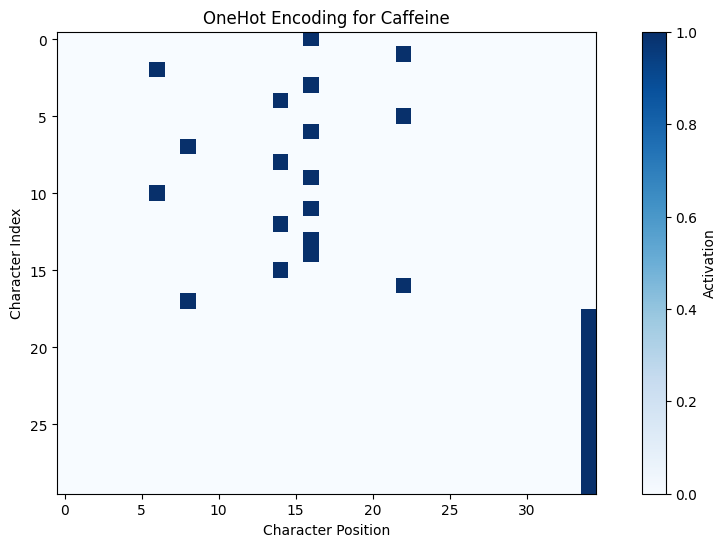


Reconstruction Accuracy:
Original: CCO                            Reconstructed: CCO
Original: C=O                            Reconstructed: C=O
Original: C1CCCCC1                       Reconstructed: C1CCCCC1
Original: c1ccccc1                       Reconstructed: c1ccccc1
Original: CN1C=NC2=C1C=CC=N2             Reconstructed: CN1C=NC2=C1C=CC=N2
Original: CC(C)C(=O)O                    Reconstructed: CC(C)C(=O)O
Original: C1=CC(=C(C=C1O)O)              Reconstructed: C1=CC(=C(C=C1O)O)
Original: NC(=O)C(Cl)Cl                  Reconstructed: NC(=O)C(Cl)Cl
Original: C(C(=O)O)N                     Reconstructed: C(C(=O)O)N
Original: C1C=CC=CC=1                    Reconstructed: C1C=CC=CC=1
Original: O=S(=O)(O)c1ccc(cc1)N          Reconstructed: O=S(=O)(O)c1ccc(cc1)N
Original: C[C@H](O)CO                    Reconstructed: C[C@H](O)CO
Original: C1C=CC=C1                      Reconstructed: C1C=CC=C1
Original: CC(=O)N(C)C                    Reconstructed: CC(=O)N(C)C
Original: C1CC1       

In [5]:
# Initialize with a more comprehensive character set
# Using the default ZINC_CHARSET which covers most organic molecules
onehot_featurizer = OneHotFeaturizer(max_length=30)  # Increased max_length for larger molecules

# Featurize both SMILES strings and molecules
try:
    smiles_encodings = onehot_featurizer.featurize(smiles_list)
    mol_encodings = onehot_featurizer.featurize(mols)

    # Check for any failed featurizations
    failed_indices = [i for i, enc in enumerate(smiles_encodings) if enc.size == 0]
    if failed_indices:
        print(f"Warning: Failed to featurize molecules at indices: {failed_indices}")
        print("Problematic SMILES:", [smiles_list[i] for i in failed_indices])

    # Visualization - only plot successful encodings
    success_indices = [i for i, enc in enumerate(smiles_encodings) if enc.size > 0]
    if success_indices:
        plt.figure(figsize=(12,6))
        plt.imshow(smiles_encodings[4], cmap='Blues')  # Caffeine encoding
        plt.title("OneHot Encoding for Caffeine")
        plt.xlabel("Character Position")
        plt.ylabel("Character Index")
        plt.colorbar(label='Activation')
        plt.show()

        # Untransform demonstration
        reconstructed_smiles = [onehot_featurizer.untransform(enc) for enc in smiles_encodings if enc.size > 0]
        original_smiles = [smiles_list[i] for i in range(len(smiles_list)) if smiles_encodings[i].size > 0]

        print("\nReconstruction Accuracy:")
        for orig, rec in zip(original_smiles, reconstructed_smiles):
            print(f"Original: {orig:30s} Reconstructed: {rec}")
    else:
        print("Error: All featurizations failed!")

except Exception as e:
    print(f"Featurization failed with error: {str(e)}")
    print("Common causes:")
    print("- SMILES contains characters not in the charset")
    print("- Molecule is too large for max_length")
    print("- Invalid SMILES strings")

# RawFeaturizer

In [6]:
from rdkit import Chem
from deepchem.feat import RawFeaturizer
import warnings

# Filter out RDKit warnings to clean up output
warnings.filterwarnings("ignore", category=UserWarning, module='rdkit')

# Create featurizer instances
smiles_featurizer = RawFeaturizer(smiles=True)
mol_featurizer = RawFeaturizer(smiles=False)

# Convert between representations with error handling
try:
    print("\nConverting molecules to SMILES:")
    smiles_from_mols = smiles_featurizer.featurize(mols)
    for mol, smiles in zip(mols, smiles_from_mols):
        print(f"Mol: {Chem.MolToSmiles(mol)} → SMILES: {smiles}")

    print("\nConverting SMILES to molecules:")
    mols_from_smiles = mol_featurizer.featurize(smiles_list)
    for smi, mol in zip(smiles_list, mols_from_smiles):
        print(f"SMILES: {smi} → Mol: {Chem.MolToSmiles(mol) if mol else 'Invalid'}")

except Exception as e:
    print(f"Error during conversion: {str(e)}")

# Round-trip validation with safety checks
print("\nRound-trip Validation:")
original = smiles_list[3]
if len(mols_from_smiles) > 3 and mols_from_smiles[3] is not None:
    round_trip = Chem.MolToSmiles(mols_from_smiles[3])
    print(f"Original: {original}\nRound-trip: {round_trip}")
else:
    print(f"Failed to process SMILES: {original}")

# Invalid SMILES handling with detailed diagnostics
print("\nInvalid SMILES Handling:")
invalid_smiles = ['C1CC', 'O=C=O', 'CC(=O)N(C)C']  # Last one is valid for comparison

for smi in invalid_smiles:
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"SMILES '{smi}' is invalid - RDKit failed to parse")
            continue

        # Try canonicalization
        canon_smi = Chem.MolToSmiles(mol)
        print(f"SMILES '{smi}' → Canonical: {canon_smi}")

    except Exception as e:
        print(f"Error processing SMILES '{smi}': {str(e)}")

# Now test with RawFeaturizer
print("\nTesting RawFeaturizer with invalid SMILES:")
results = mol_featurizer.featurize(invalid_smiles)
for smi, result in zip(invalid_smiles, results):
    status = "Success" if result is not None else "Failed"
    print(f"SMILES '{smi}': {status}")
    if result:
        print(f"  → Result: {Chem.MolToSmiles(result)}")

[00:52:23] SMILES Parse Error: unclosed ring for input: 'C1CC'
[00:52:23] SMILES Parse Error: unclosed ring for input: 'C1CC'
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)



Converting molecules to SMILES:
Mol: CCO → SMILES: CCO
Mol: C=O → SMILES: C=O
Mol: C1CCCCC1 → SMILES: C1CCCCC1
Mol: c1ccccc1 → SMILES: c1ccccc1
Mol: Cn1cnc2ncccc21 → SMILES: Cn1cnc2ncccc21
Mol: CC(C)C(=O)O → SMILES: CC(C)C(=O)O
Mol: Oc1cccc(O)c1 → SMILES: Oc1cccc(O)c1
Mol: NC(=O)C(Cl)Cl → SMILES: NC(=O)C(Cl)Cl
Mol: NCC(=O)O → SMILES: NCC(=O)O
Mol: c1ccccc1 → SMILES: c1ccccc1
Mol: Nc1ccc(S(=O)(=O)O)cc1 → SMILES: Nc1ccc(S(=O)(=O)O)cc1
Mol: C[C@H](O)CO → SMILES: C[C@H](O)CO
Mol: C1=CCC=C1 → SMILES: C1=CCC=C1
Mol: CC(=O)N(C)C → SMILES: CC(=O)N(C)C
Mol: C1CC1 → SMILES: C1CC1

Converting SMILES to molecules:
SMILES: CCO → Mol: CCO
SMILES: C=O → Mol: C=O
SMILES: C1CCCCC1 → Mol: C1CCCCC1
SMILES: c1ccccc1 → Mol: c1ccccc1
SMILES: CN1C=NC2=C1C=CC=N2 → Mol: Cn1cnc2ncccc21
SMILES: CC(C)C(=O)O → Mol: CC(C)C(=O)O
SMILES: C1=CC(=C(C=C1O)O) → Mol: Oc1cccc(O)c1
SMILES: NC(=O)C(Cl)Cl → Mol: NC(=O)C(Cl)Cl
SMILES: C(C(=O)O)N → Mol: NCC(=O)O
SMILES: C1C=CC=CC=1 → Mol: c1ccccc1
SMILES: O=S(=O)(O)c1ccc(cc1)N

<ipython-input-6-606f2aac9658>:60: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if result:


# UserDefinedFeaturizer


Custom Feature Statistics:
Average molecular weight (mol_weight): 86.37
Max ring count (num_rings): 2.0


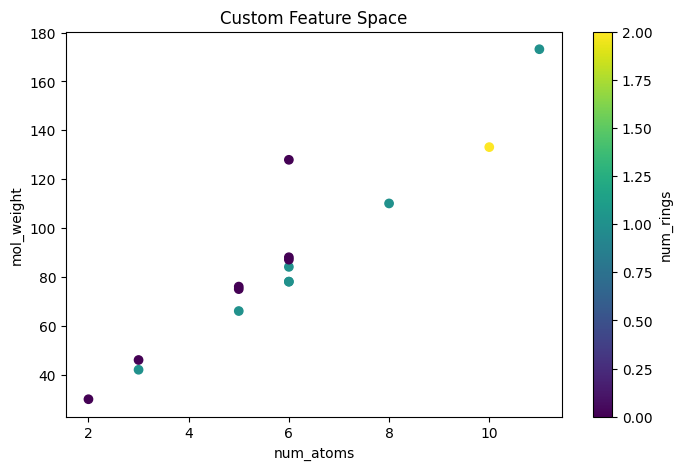


Feature names stored in metadata: ['num_atoms', 'mol_weight', 'num_rings']


In [7]:
# Create a NumpyDataset with custom features
dataset = dc.data.NumpyDataset(
    X=np.array(custom_features, dtype=np.float32),
    ids=smiles_list
)

# For tracking feature names, we'll create a separate dictionary
feature_names = ['num_atoms', 'mol_weight', 'num_rings']

# Initialize featurizer - note this is just for demonstration since we're using precomputed features
user_featurizer = UserDefinedFeaturizer(feature_fields=feature_names)

# Show feature statistics with proper labels
print("\nCustom Feature Statistics:")
print(f"Average molecular weight ({feature_names[1]}): {np.mean(dataset.X[:, 1]):.2f}")
print(f"Max ring count ({feature_names[2]}): {np.max(dataset.X[:, 2])}")

# Visualization with proper labels
plt.figure(figsize=(8,5))
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.X[:,2])
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Custom Feature Space')
plt.colorbar(label=feature_names[2])
plt.show()

# If you need to track feature names with the dataset, you can add them as metadata:
dataset.metadata = {'feature_names': feature_names}
print("\nFeature names stored in metadata:", dataset.metadata['feature_names'])